#Housing Prices Prediction using various Regression Techniques
###Problem Description: 
Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.

###Import Libraries:

In [1199]:
import numpy as np
import pandas as pd
import matplotlib
%matplotlib inline 
#Enable Iniline Plotting
import matplotlib.pyplot as plt
from scipy.stats import skew

###Import Data:

In [1200]:
traindata=pd.read_csv('../data/train.csv')
traindata=traindata.loc[:,'MSSubClass':'SalePrice']
traindata.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


###Feature Transformation
We need to handle the skewed Data, we will transform all non categorical skewed features. We must remember the index of the skewed feature. Next we will convert the categorical features and at last we will divide the Training set.

Overview of the steps followed:
* Transform y part
* Get list of non categorical features
* Calculate skewness of non categorical features
* Apply log transformation to skewed data
* Convert Categorical feature using bit pair encoding
* Fill NaN will mean of the column
* Shuffle the data and divide into Train and CV Sets

In [1201]:
traindata['SalePrice']=np.log1p(traindata['SalePrice'])
#Get non categorical data
numeric_feats = traindata.dtypes[traindata.dtypes != "object"].index
#traindata[numeric_feats] = (traindata[numeric_feats] - traindata[numeric_feats].mean()) / (traindata[numeric_feats].max() - traindata[numeric_feats].min())
skewed_feats = traindata[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index
#Apply transformation
traindata[skewed_feats] = np.log1p(traindata[skewed_feats])

#Convert categorical features
traindata=pd.get_dummies(traindata)


#Remove NaN with mean of the values
traindata=traindata.fillna(np.round(traindata.mean()))

#Shuffle the data
traindata = traindata.sample(frac=1).reset_index(drop=True)

#Generate  X and y datasets

#Make 20% of the Data Test Set for evaluating the different models
testsize=int(traindata.shape[0]*0.8)
X=traindata.drop('SalePrice',1)[0:testsize]
y=traindata[0:testsize]
y=y.loc[:,"SalePrice"]
Xtest=traindata.drop('SalePrice',1)[testsize+1:]
ytest=traindata[testsize+1:]
ytest=ytest.loc[:,"SalePrice"]

X=X.sort_index(axis=1)
Xtest=Xtest.sort_index(axis=1)


###Training using CART Trees
First we will train the model using CART decision Trees.

In [1202]:
from sklearn import tree
regressorCART=tree.DecisionTreeRegressor()
regressorCART=regressorCART.fit(X,y)

Plotting the error of the actual value (y is in mormalized form)

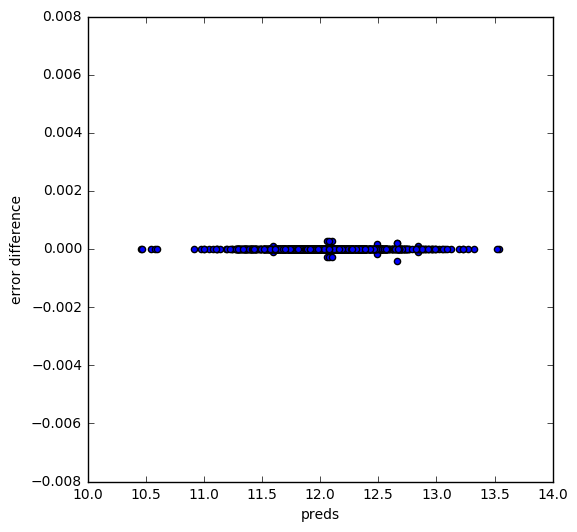

In [1203]:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":regressorCART.predict(X), "true":y})
preds["error difference"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "error difference",kind = "scatter")

####Visualizing the Decision Tree

In [1204]:
'''
import pydotplus 
dot_data = tree.export_graphviz(regressorCART, out_file=None, 
                         feature_names=list(X.columns.values),  
                         class_names='SalesPrice' , 
                         filled=True, rounded=True,  
                         special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data)  
graph.write_pdf("iris.pdf") 
'''

'\nimport pydotplus \ndot_data = tree.export_graphviz(regressorCART, out_file=None, \n                         feature_names=list(X.columns.values),  \n                         class_names=\'SalesPrice\' , \n                         filled=True, rounded=True,  \n                         special_characters=True)\ngraph = pydotplus.graph_from_dot_data(dot_data)  \ngraph.write_pdf("iris.pdf") \n'

###Training using Random Forest

In [1205]:
from sklearn.ensemble import RandomForestRegressor
regressorRandomForest=RandomForestRegressor(n_estimators=10)
regressorRandomForest=regressorRandomForest.fit(X,y)

Plotting the error in prediction

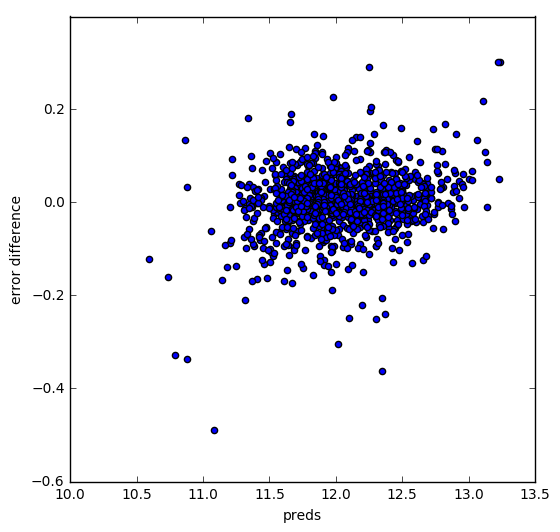

In [1206]:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":regressorRandomForest.predict(X), "true":y})
preds["error difference"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "error difference",kind = "scatter")

###Training using Linear Regression Ridge
We will now use regularized linear Regression to Train the model. First we need to determine the value of lambda (the regularization parameter). We will calculate the root mean square error using different values of lambda.

In [1207]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, Lasso, LassoLarsCV
from sklearn.model_selection import cross_val_score, cross_val_predict


def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge=RidgeCV(alphas=alphas)
cv_ridge=cv_ridge.fit(X,y)
rmse_cv(cv_ridge).mean()

0.13462757028289898

In [1208]:
regressorRidge = cv_ridge
regressorRidge=regressorRidge.fit(X,y)


####Plot the error

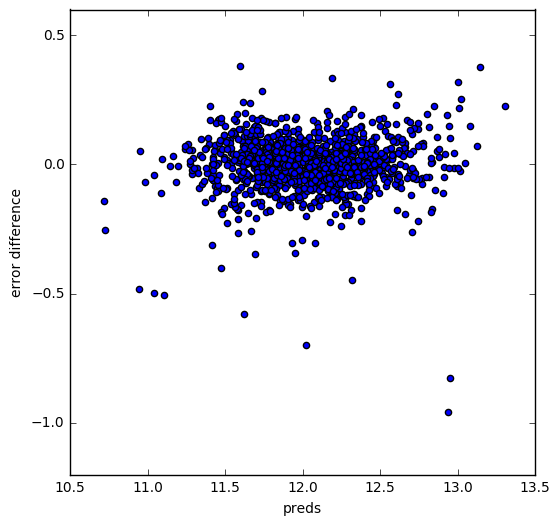

In [1209]:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":regressorRidge.predict(X), "true":y})
preds["error difference"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "error difference",kind = "scatter")

###Training using Linear Regression Lasso
We will now use regularized linear Regression to Train the model. First we need to determine the value of alphas (the regularization parameter). We will calculate the root mean square error using different values of alphas.

In [1210]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_lasso= LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X, y)
rmse_cv(cv_lasso).mean()

0.13240816325392762

In [1211]:
regressorLasso = cv_lasso
regressorLasso=regressorLasso.fit(X,y)

####Plot the error

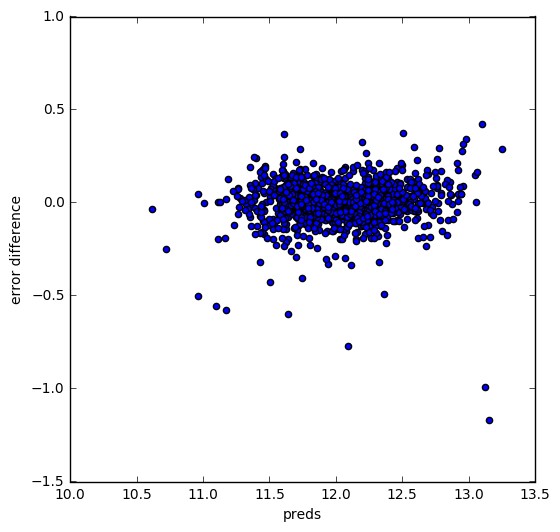

In [1212]:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":cv_lasso.predict(X), "true":y})
preds["error difference"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "error difference",kind = "scatter")

Nice! The lasso performs even better so we'll just use this one to predict on the test set. Another neat thing about the Lasso is that it does feature selection for you - setting coefficients of features it deems unimportant to zero. Let's take a look at the coefficients:

In [1213]:
coef = pd.Series(regressorLasso.coef_, index = X.columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 86 variables and eliminated the other 202 variables


###Testing different models using the Test Set


In [1214]:
#Test Set Preview
Xtest.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley_Grvl,Alley_Pave,BedroomAbvGr,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,...,Street_Grvl,Street_Pave,TotRmsAbvGrd,TotalBsmtSF,Utilities_AllPub,Utilities_NoSeWa,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
1169,6.593045,6.576470,0.0,0,0,3,1,0,0,0,...,0,1,6,6.593045,1,0,5.579730,1996,1997,2008
1170,6.982863,0.000000,0.0,0,0,3,1,0,0,0,...,0,1,6,6.915723,1,0,0.000000,1922,1950,2006
1171,7.723120,0.000000,0.0,0,0,3,1,0,0,0,...,0,1,7,7.501082,1,0,5.117994,1953,1953,2007
1172,7.496652,0.000000,0.0,0,0,1,1,0,0,0,...,0,1,6,7.314553,1,0,0.000000,1959,1997,2010
1173,6.771936,6.257668,0.0,0,0,3,1,0,0,0,...,0,1,8,6.705639,1,0,4.804021,1955,1955,2008


####CART Model:

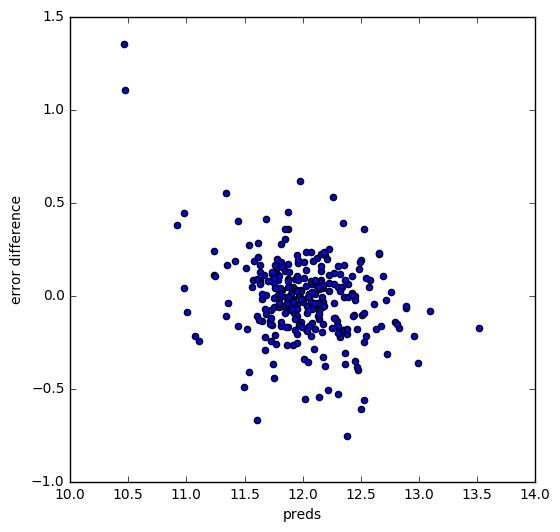

In [1215]:
predictedCART =regressorCART.predict(Xtest)

matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":predictedCART, "true":ytest})
preds["error difference"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "error difference",kind = "scatter")

####Random Forest:

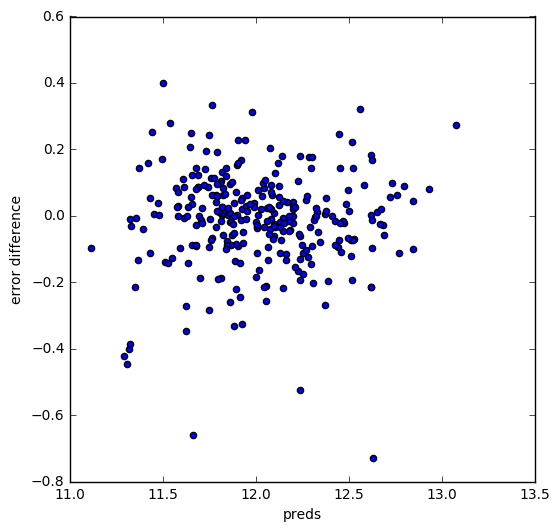

In [1216]:
predictedRandomForest = regressorRandomForest.predict(Xtest)

matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":predictedRandomForest, "true":ytest})
preds["error difference"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "error difference",kind = "scatter")

####Linear Regression using Ridge Regularization

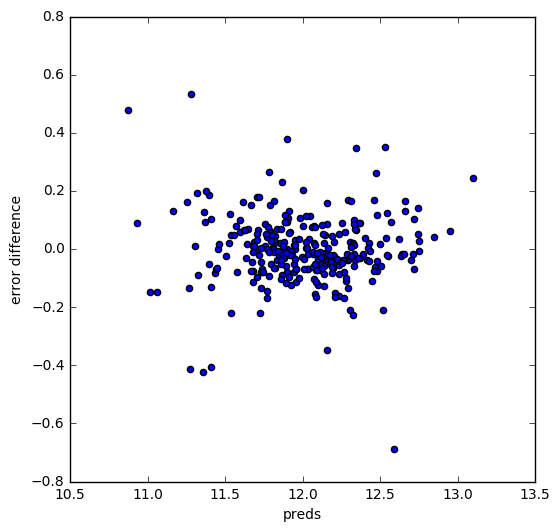

In [1217]:
#predictedRidge= cross_val_predict(regressorRidge, Xtest, ytest, cv=10)
predictedRidge=regressorRidge.predict(Xtest)

matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":predictedRidge, "true":ytest})
preds["error difference"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "error difference",kind = "scatter")

###Calculate the Prediction accuracy for different models

In [1218]:

scoreCART=regressorRidge.score(Xtest,ytest)
scoreRandomForest=regressorRandomForest.score(Xtest,ytest)
scoreRidge=regressorRidge.score(Xtest,ytest)
scoreLasso=regressorLasso.score(Xtest,ytest)
print("CART Accuracy: "+str(scoreCART*100)+"%")
print("Random Forest Accuracy: "+str(scoreRandomForest*100)+"%")
print("Linear Regression(Ridge) Accuracy: "+str(scoreRidge*100)+"%")
print("Linear Regression(Lasso) Accuracy: "+str(scoreLasso*100)+"%")
modelsScore={scoreCART:"CART",scoreRandomForest:"Random Forest",scoreRidge:"Linear Regression",scoreLasso:"Lasso Regression"}
maxScoreModel=modelsScore[max(modelsScore)]
print("Model with Highest Accuracy is: "+maxScoreModel)

CART Accuracy: 90.2540129952%
Random Forest Accuracy: 85.939295302%
Linear Regression(Ridge) Accuracy: 90.2540129952%
Linear Regression(Lasso) Accuracy: 91.2143583181%
Model with Highest Accuracy is: Lasso Regression


###Display Predictions vs Actual  using Linear Regression
Get back the data from log(1+p) form by applying exponentation
####Test Set:

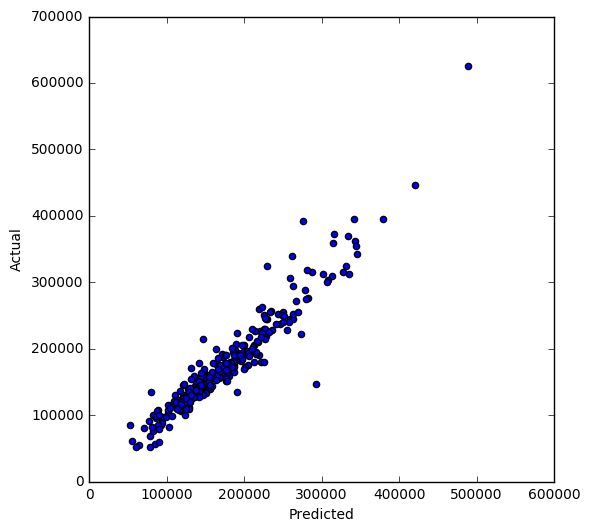

In [1219]:
predictedRidge=np.expm1(predictedRidge) #Bring Back the non Log Data
ytest=np.expm1(ytest)


#Plot the Graph
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"Predicted":predictedRidge, "Actual":ytest})
preds.plot(x = "Predicted", y = "Actual",kind = "scatter")

Woah that looks like a pretty amazing prediction lets try the Training Set now!
####Training Set:

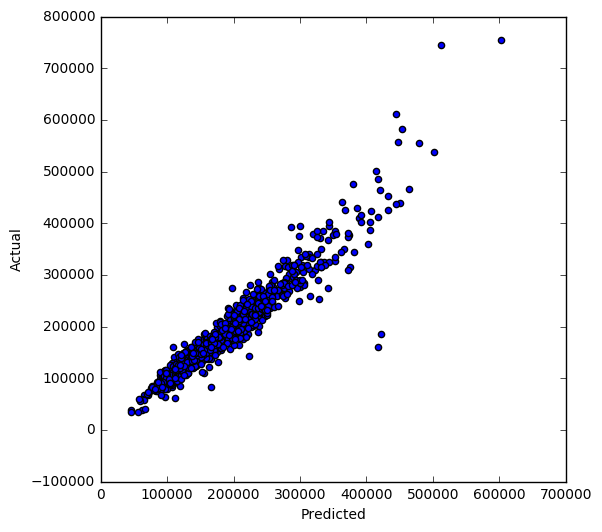

In [1220]:
predictedRidgeTrain=np.expm1(regressorRidge.predict(X)) #Bring Back the non Log Data
y=np.expm1(y)

#Plot the Graph
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"Predicted":predictedRidgeTrain, "Actual":y})
preds.plot(x = "Predicted", y = "Actual",kind = "scatter")

###Test on Actual Test Data

In [1221]:

#Get the complete Data Set Now
Xcomplete=traindata.drop('SalePrice',1)
ycomplete=traindata.loc[:,'SalePrice']
Xcomplete=Xcomplete.sort_index(axis=1)

#Fit the values
regressorLasso.fit(Xcomplete,ycomplete)

#load Test Data
testdata=pd.read_csv('../data/test.csv')
Ids=testdata.loc[:,'Id']
testdata=testdata.drop('Id',1)


#Use the existing skewed index
testdata[skewed_feats] = np.log1p(testdata[skewed_feats])

#Bit value encoding
testdata=pd.get_dummies(testdata)

testdata=testdata.fillna(np.round(Xcomplete.mean()))
#Generate empty datadrame with same feature names
df_copy = pd.DataFrame(columns=Xcomplete.columns)

#Combine dataframes
result=df_copy.append(testdata,ignore_index=True)
result.sort_index(axis=1)
result=result.fillna(0)

#Predict values
predictedValues=regressorLasso.predict(result)
predictedValues=np.expm1(predictedValues)
outputdataFrame=pd.DataFrame({'Id':Ids,'SalePrice':predictedValues})

#Save to csv
outputdataFrame.to_csv('output.csv',index=False)
outputdataFrame.head()


,Id,SalePrice
0,1461,119958.967679
1,1462,151483.281377
2,1463,180199.733830
3,1464,197514.340671
4,1465,202432.940725
